## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [4]:
### Read the data frame from pickle file

data_dir='../resource/asnlib/publicdata/Data'
state='NY'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


In [5]:
#read data
filename=data_dir+'/recon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())

8026


In [6]:
tmp=df.filter(df.Station=='USC00306411').toPandas()
tmp.head(1)

,Station,Measurement,Values,Year,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,res_1,...,res_4,res_5,res_mean,total_var,Dist_coast,Latitude,Longitude,Elevation,State,Name
0,USC00306411,SNWD,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",1941,0.051522,3.142275,21.556489,-13.371331,2.323004,1.0,...,0.996296,0.996162,0.524031,433356.0,370.621002,44.633301,-74.833298,228.899994,NY,PARISHVILLE 1 WNW


In [7]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,USW00014735,1943,276.110910
1,USW00014735,1945,811.633243
2,USW00014735,1947,-224.957913
3,USW00014735,1948,1013.949215
4,USW00014735,1950,-606.551583


In [8]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(2)

station,USC00300015,USC00300023,USC00300047,USC00300055,USC00300063,USC00300077,USC00300085,USC00300090,USC00300093,USC00300159,...,USW00014786,USW00014797,USW00014798,USW00094704,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## How many of the station/years are NaN?

We have 328 stations over 121 years 1893 to 2013. But about 80% are Nan.

We want to focus on more recent years to get a more dense matrix.

Text(0,0.5,'Number of stations')

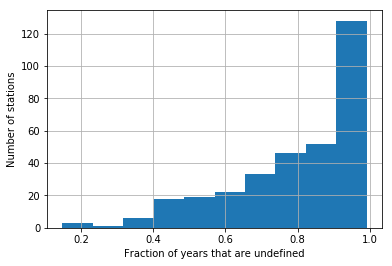

In [9]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0,0.5,'fraction of stations that are undefined')

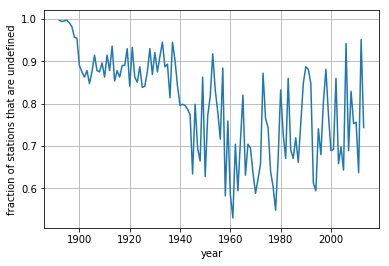

In [10]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [11]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(2)

station,USC00300023,USC00300055,USC00300063,USC00300077,USC00300085,USC00300093,USC00300183,USC00300220,USC00300321,USC00300331,...,USW00014757,USW00014768,USW00014771,USW00014786,USW00014798,USW00094725,USW00094728,USW00094745,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
1961,867.065629,NaN,NaN,515.942376,1571.789631,485.029119,993.619230,942.604512,893.132525,794.575403,...,1006.995308,221.883397,989.857627,755.777099,773.899671,-361.792316,636.070848,1867.407905,1195.898126,954.159825
1962,NaN,NaN,NaN,129.522856,-533.393761,-297.540498,-12.063835,-156.916601,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-158.201279,NaN,NaN,889.785212,-355.145068


In [12]:
A=isnan(year_station_table)
Undef = sum(sum(A))
Total=A.shape[0]*A.shape[1]
print('After removing years before 1960 the fraction of the entries that are undefined is %8.4f'%(Undef/Total))

After removing years before 1960 the fraction of the entries that are undefined is   0.6609


Text(0,0.5,'Number of stations')

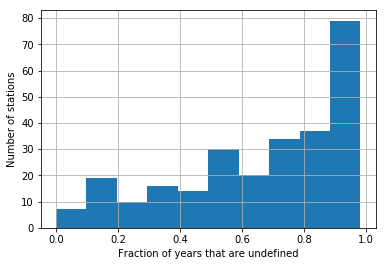

In [13]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [14]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  758.2918640369495
RMS removing mean-by-station=  705.4292104929526 reduction= 52.862653543996885
RMS removing mean-by-year   =  539.1348422845654 reduction= 219.15702175238414


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [15]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 758.2918640369495
0 after removing mean by year    = 539.1348422845654
0 after removing mean by stations= 494.32914321840843
1 after removing mean by year    = 493.70297376472774
1 after removing mean by stations= 493.6632897850066
2 after removing mean by year    = 493.6591491226663
2 after removing mean by stations= 493.65846529894975
3 after removing mean by year    = 493.65830747983756
3 after removing mean by stations= 493.6582643635312
4 after removing mean by year    = 493.6582517716338
4 after removing mean by stations= 493.6582480052353


In [16]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961   -0.136698
1962   -0.140416
1963   -0.151863
1964   -0.151893
1965   -0.122998
Name: mean_by_year, dtype: float64

## Is there a trend?

We see that year has a larger influence on `coeff_2` (defining whether snow season is early or late) than location.

We would like to see if there is a trend over the years.

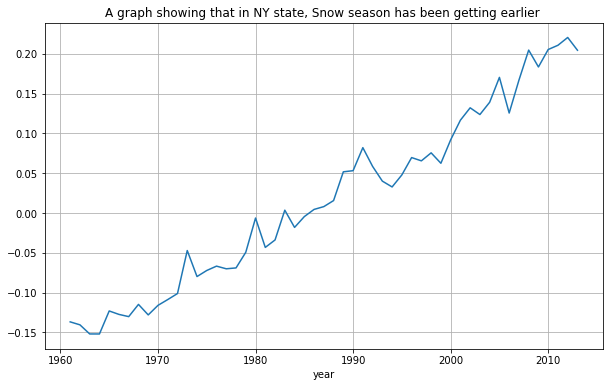

In [17]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in NY state, Snow season has been getting earlier ');

/usr/local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


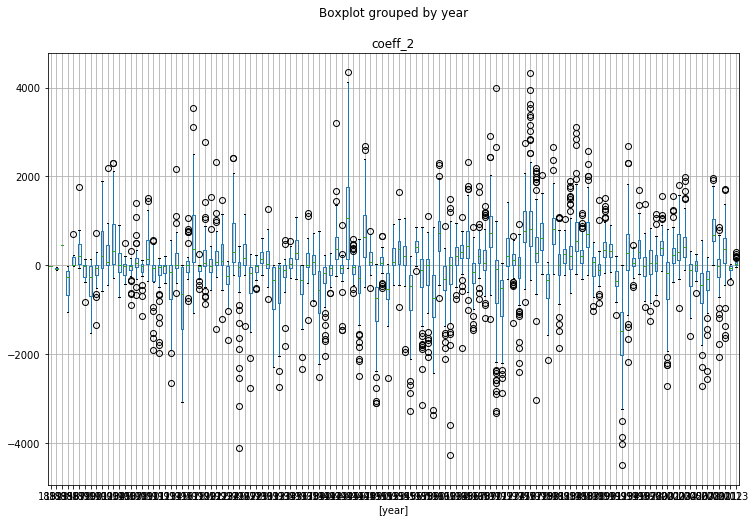

In [18]:
pdf[['year', 'coeff_2']].boxplot(by='year',figsize=[12,8])

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.